In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

In [3]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  print(f"Input to vqgan shape = {x.shape}")
  z, _, [_, _, indices] = model.encode(x)
  print(z.shape)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

In [5]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown


def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

def stack_reconstructions(input, x0, titles=[]):
  assert input.size == x0.size
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (2*w, h))
  img.paste(input, (0,0))
  img.paste(x0, (1*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255)) # coordinates, text, color, font
  return img

In [6]:
"""
Text 2 Image with VQGAN Model
Author: Nicholas Mesa-Cucalon
10-623 Generative AI
"""

"""
Imports
"""
import sys
sys.path.append(".")
import yaml
from taming.models.vqgan import VQModel, GumbelVQ
import numpy as np
import torch
from omegaconf import OmegaConf
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import CLIPTextModelWithProjection, AutoTokenizer

"""
Helper Functions
"""
def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

"""
Model 1: Encoder Input
"""

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class T2IEncoderInput(nn.Module):
    def __init__(self, d_proj : int,
                       res_h_dim : int,
                       config_path : str,
                       ckpt_path : str,
                       is_gumbel : bool,
    ):
        super(T2IEncoderInput, self).__init__()
        # Store variables
        self.d_proj = d_proj
        self.res_h_dim = res_h_dim
        self.num_channels = 3
        # CLIP Text Model
        self.clip_txt = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        # Initialize Linear Layer Stack
        self.grounding_stack = nn.ModuleList([
                    nn.Linear(d_proj, res_h_dim ** 2),
                    nn.Linear(d_proj, res_h_dim ** 2),
                    nn.Linear(d_proj, res_h_dim ** 2)
                ])
        # Initialize VQGAN Config
        config = load_config("logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
        self.vqgan = load_vqgan(config, ckpt_path=ckpt_path, is_gumbel=is_gumbel).to(device)
        # Freeze CLIP Modules
        for param in self.clip_txt.parameters():
            param.requires_grad = False
        # Freeze VQGAN modules
        for param in self.vqgan.parameters():
            param.requires_grad = False

    def encode_text(self, x):
        # Tokenize text
        inputs = self.clip_tokenizer(x, padding = "max_length",
            max_length = 77, truncation = True, return_tensors = "pt").to(device)
        # Get text features
        txt_features = self.clip_txt(**inputs).text_embeds
        # Get the batch size
        b, _ = txt_features.shape
        # Project it into the encoder input dimension
        text_embd = torch.stack([layer(txt_features) for layer in self.grounding_stack],dim = 1)
        # Return a [b, 3, res_h_dim, res_h_dim] view of our grounded text features
        return text_embd.view((b,self.num_channels,self.res_h_dim,self.res_h_dim))

    def forward(self, x):
        # Encode text
        x = self.encode_text(x)
        # Preprocess encoded text for the VQGAN
        x = preprocess_vqgan(x)
        # Encode text with VQGAN Encoder
        z, _, _ = self.vqgan.encode(x)
        # Return a reconstructed version of the encoded text embedding
        return self.vqgan.decode(z)


2024-12-09 01:38:57.541951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 01:38:57.554447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 01:38:57.569663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 01:38:57.574163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 01:38:57.585240: I tensorflow/core/platform/cpu_feature_guar

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/tmp/ipykernel_24926/162412365.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
huggingface/tokenizers: The 

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/tmp/ipykernel_24926/2012921810.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


input is of size: torch.Size([1, 3, 512, 512])
Input to vqgan shape = torch.Size([1, 3, 512, 512])
torch.Size([1, 256, 64, 64])
VQGAN --- GumbelVQ: latent shape: torch.Size([64, 64])


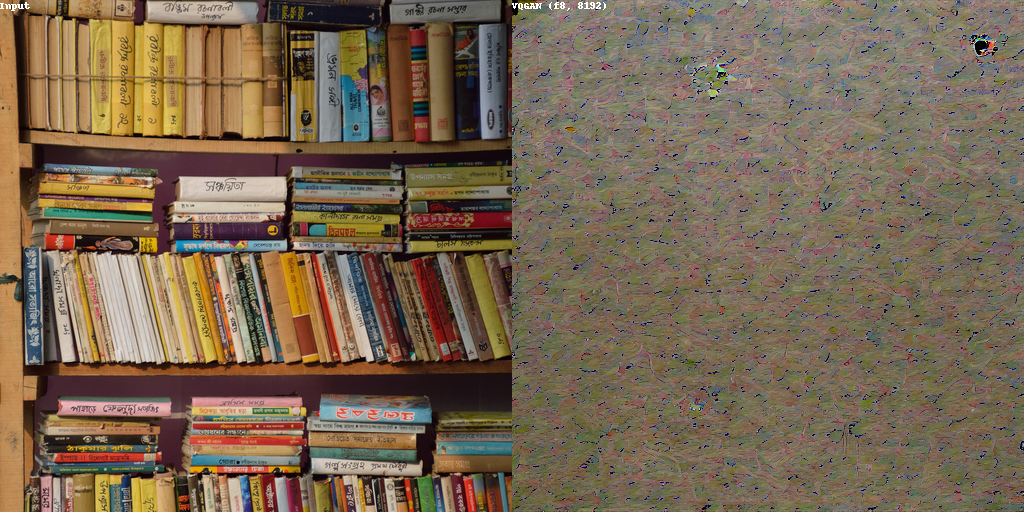

In [10]:
config32x32 = load_config("logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
model32x32 = load_vqgan(config32x32, ckpt_path="logs/vqgan_gumbel_f8/checkpoints/last.ckpt", is_gumbel=True).to(device)
config_path = "logs/vqgan_gumbel_f8/configs/model.yaml"
chkpt_path = "logs/vqgan_gumbel_f8/checkpoints/last.ckpt"
model = T2IEncoderInput(512, 512, config_path, chkpt_path, True)
model_path = "encoder_input.pth"
model.load_state_dict(torch.load(model_path))

model.eval()
model.to(device)

titles=["Input", "VQGAN (f8, 8192)"]

def reconstruction_pipeline(url, size=320):
  x_vqgan = preprocess(download_image(url), target_image_size=size, map_dalle=False)
  x_vqgan = x_vqgan.to(device)

  print(f"input is of size: {x_vqgan.shape}")
  x0        = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model32x32)
  x0_t2i    = model("A group of people sitting around a table with food and drinks.")
  pil_input = custom_to_pil(preprocess_vqgan(x_vqgan[0]))
  pil_x1    = custom_to_pil(x0_t2i[0])
  img       = stack_reconstructions(pil_input, pil_x1, titles=titles)
  return img

reconstruction_pipeline(url='https://heibox.uni-heidelberg.de/f/6f12b330eb564d288d76/?dl=1', size=512)
